In [179]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [208]:
class Processor(processor.ProcessorABC):
    def __init__(self, wp_btag=0):
        self._wp_btag = wp_btag
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "cutflow": defaultdict(int),
            "templates": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).StrCategory(
                                [], name="cutflow", label="Cutflow", growth=True
                            ).Reg(
                                50, 100, 700, name="pt", label=r"$p_T$"
                            ).Reg(
                                50, 0, 150, name="mass", label=r"mass"
                            ).Reg(
                                50, 0, 150, name="mreg", label=r"mreg"
                            ).Reg(
                                50, 0, 1, name="ddb", label=r"ddb"
                            ).Double()
                        ),
        }
           
        
    def process(self, events):
        
        output = self.accumulator
        #output['cutflow']['all'] += len(events)
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        isQCDMC = 'QCD' in dataset
        
        selection = PackedSelection()
        
        if not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        fatjets = events.ScoutingFatJet
        fatjets["pn_Hbb"] = ak.where((fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD) == 0, 0, (fatjets.particleNet_prob_Hbb / (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD)))
        jets = events.ScoutingJet
        jets["pn_b"] = ak.where((jets.particleNet_prob_b + jets.particleNet_prob_g) == 0, 0, (jets.particleNet_prob_b / (jets.particleNet_prob_b + jets.particleNet_prob_g)))
        
        # require MET
        met = events.ScoutingMET
        selection.add('met', met.pt > 50)
        
        # require at least one good muon
        goodmuon = (
            (events.ScoutingMuon.pt > 55)
            & (abs(events.ScoutingMuon.eta) < 2.5)
            #& (abs(events.ScoutingMuon.trk_dxy) < 0.2)
            #& (abs(events.ScoutingMuon.trk_dz) < 0.5)
        )
        
        nmuons = ak.sum(goodmuon, axis=1)
        selection.add('onemuon', (nmuons > 0))
        
        # create and require good leptonic W 
        leadingmuon = ak.firsts(events.ScoutingMuon[goodmuon])
        leptonicW = met + leadingmuon
        selection.add('leptonicW', leptonicW.pt > 100)
        
        # require at least one b-jet in the same hemisphere of the leading muon
        dphi = abs(jets.delta_phi(leadingmuon))
        jetsamehemisp = jets[dphi < 2]
        bjets = (jetsamehemisp.pn_b > self._wp_btag)
        nbjets = ak.sum(bjets, axis=1)
        selection.add('onebjet', (nbjets > 0))

        # require fatjet away from the leading muon
        dphi = abs(fatjets.delta_phi(leadingmuon))
        is_away = (dphi > 2)
        nfatjets = ak.sum(is_away, axis=1)
        selection.add('onefatjet', (nfatjets > 0))
        
        hadronictop = ak.firsts(fatjets[is_away])
            
        regions = {
            'all': ['met','onemuon','leptonicW','onebjet','onefatjet'],
            'noselection': [],
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        def fill(region, jet, _cut=None):
            #selections = regions[region]
            cut = selection.all(_cut)

            left_after_cut = normalize(hadronictop.pt, cut)
            output['cutflow'][_cut] += len(left_after_cut)
            
            output['templates'].fill(
                dataset=dataset,
                region=region,
                cutflow=np.repeat(_cut, len(left_after_cut)),
                pt=normalize(jet.pt, cut),
                mass=normalize(jet.mass, cut),
                mreg=normalize(jet.particleNet_mass, cut),
                ddb=normalize(jet.pn_Hbb, cut),
            )
            
        # at least one fatjet
        selection.add('min', ak.num(fatjets) > 0)
        fill('all', ak.firsts(fatjets), 'min')
            
        for region, cuts in regions.items():
            for cut in cuts:
                fill(region, hadronictop, cut)
            
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [209]:
fileset = {
    "TTtoLNu2Q" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22/230131_071621/0000/nanoaod_1.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    maxchunks = 10,
)

out = futures_run(
    fileset,
    treename="Events",
    processor_instance=p
)

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [173]:
out

{'sumw': defaultdict(float, {'TTtoLNu2Q': 231551.265625}),
 'cutflow': defaultdict(int,
             {'min': 658,
              'met': 431,
              'onemuon': 75,
              'leptonicW': 32,
              'onebjet': 75,
              'onefatjet': 64}),
 'templates': Hist(
   StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all'], growth=True, name='region', label='Region'),
   StrCategory(['min', 'met', 'onemuon', 'leptonicW', 'onebjet', 'onefatjet'], growth=True, name='cutflow', label='Cutflow'),
   Regular(50, 100, 700, name='pt', label='Leading fatjet $p_T$'),
   Regular(50, 0, 150, name='mass', label='Leading fatjet mass'),
   Regular(50, 0, 150, name='mreg', label='Leading fatjet regressed mass'),
   Regular(50, 0, 1, name='ddb', label='Leading fatjet Double b score'),
   storage=Double()) # Sum: 111.0 (1335.0 with flow)}

In [211]:
import json

fileset = {}

with open("files.json") as fin:
    fileset = json.load(fin)

In [212]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

from dask.distributed import performance_report
from dask_jobqueue import HTCondorCluster, SLURMCluster

env_extra = [
    f"export PYTHONPATH=$PYTHONPATH:{os.getcwd()}",
]

cluster = LPCCondorCluster(
    ship_env=True,
)

cluster.adapt(minimum=1, maximum=100)
client = Client(cluster)

print("Waiting for at least one worker...")
client.wait_for_workers(1)

uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

output = processor.run_uproot_job(
            fileset,
            "Events",
            processor_instance=Processor(),
            executor=processor.dask_executor,
            executor_args={
                "schema": ScoutingNanoAODSchema,
                "savemetrics": True,
                "retries": 3,
                "client": client,
            },
            chunksize=10000,
            #maxchunks=args.max,
        )

ModuleNotFoundError: No module named 'lpcjobqueue'

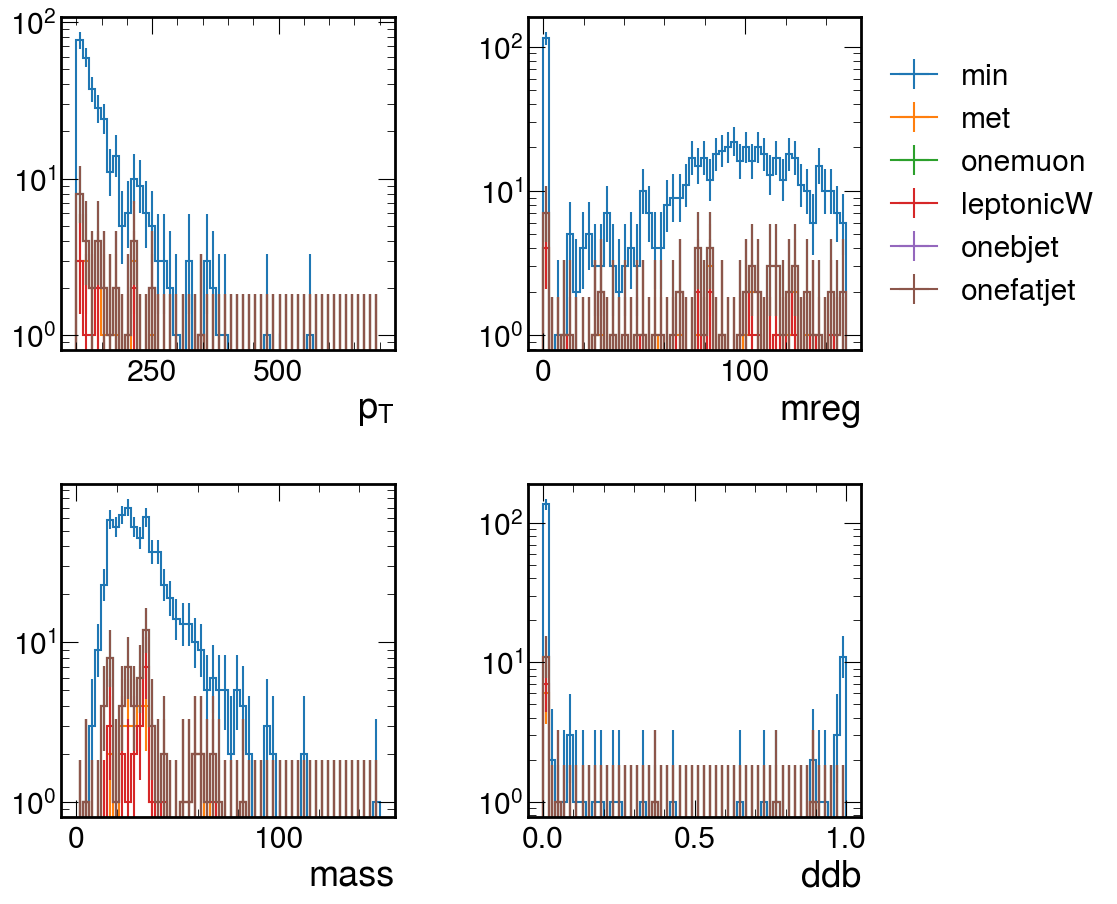

In [210]:
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

row = 0
column = 0
for i, var in enumerate(['pt', 'mass','mreg','ddb']):
    h = out['templates'].project('cutflow',var)    
    for cut in ['min', 'met', 'onemuon', 'leptonicW', 'onebjet', 'onefatjet']:
    
        if i == 2:
            row = 0
            column = 1
    
        mplhep.histplot(h[hist.loc(cut), :], label=cut, ax=axs[row, column])
        axs[row, column].set_yscale('log')
        
    row += 1
        
axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [36]:
events = NanoEventsFactory.from_root(
    fileset['TTtoLNu2Q'][0],
    schemaclass=ScoutingNanoAODSchema
).events()